# **Project: Generating sample MNIST Hand-written images using Generative Adversarial Networks (GANs):**
The objective of this project is to demonstrate how to generate sample MNIST hand-written images, using Generative Adversarial Networks (GANS).

### Author: Mohsen Ghazel (mghazel)
* Date: April 9th, 2021

## **Part 1: Imports and global variables:**

###**1.1) Standard scientific Python imports:**

In [1]:
# numpy
import numpy as np
# matplotlib
import matplotlib.pyplot as plt
# - import sklearn to use the confusion matrix function
from sklearn.metrics import confusion_matrix
# import imread
from skimage.io import imread
# import itertools
import itertools
# opencv
import cv2
# tensorflow
import tensorflow as tf
# pandas imports
import pandas as pd

# keras input layer
from tensorflow.keras.layers import Input
# keras conv2D layer
from tensorflow.keras.layers import Conv2D
# keras MaxPooling2D layer
from tensorflow.keras.layers import MaxPooling2D
# keras Dense layer
from tensorflow.keras.layers import Dense
# keras Flatten layer
from tensorflow.keras.layers import Flatten
# keras Dropout layer
from tensorflow.keras.layers import Dropout
# keras model
from tensorflow.keras.models import Model
# keras sequential model
from tensorflow.keras.models import Sequential
# keras LeakyReLU layer
from tensorflow.keras.layers import LeakyReLU
# keras LeakyReLU layer
from tensorflow.keras.layers import BatchNormalization
# optimizers
# SGD
from tensorflow.keras.optimizers import SGD
# Adam
from tensorflow.keras.optimizers import Adam
# random number generators values
# seed for reproducing the random number generation
from random import seed
# random integers: I(0,M)
from random import randint
# random standard unform: U(0,1)
from random import random
# time
import datetime
# I/O
import os
# sys
import sys

In [2]:
# check for successful package imports and versions
# python
print("Python version : {0} ".format(sys.version))
# OpenCV
print("OpenCV version : {0} ".format(cv2.__version__))
# numpy
print("Numpy version  : {0}".format(np.__version__))
# tensorflow
print("Tensorflow version  : {0}".format(tf.__version__))

Python version : 3.7.10 (default, May  3 2021, 02:48:31) 
[GCC 7.5.0] 
OpenCV version : 4.1.2 
Numpy version  : 1.19.5
Tensorflow version  : 2.4.1


###**1.2) Global variables:**

In [3]:
# -set the random_state seed = 100 for reproducibilty
random_state_seed = 100

# the number of visualized images
num_visualized_images = 25

#------------------------------------------
# GANs Hyper-parameters Parameters:
#------------------------------------------
# Dimensionality of the latent space
latent_dim = 100
#------------------------------------------
# Config parameters
# batch-sze
batch_size = 32
# the number of epochs
epochs = 30000
# after every sample_period steps generate 
# and save some data
sample_period = 500 
#------------------------------------------

##**Part 2: Load MNIST Dataset**
###**2.1) Load the MNIST dataset :**
* Load the MNIST dataset of handwritten digits:
  * 60,000 labelled training examples
  * 10,000 labelled test examples
  * Each handwritten example is 28x28 pixels binary image.

In [4]:
# Load in the data
mnist = tf.keras.datasets.mnist
# load the training and test data
(x_train, y_train), (x_test, y_test) = mnist.load_data()
# map inputs to (-1, +1) for better training
x_train, x_test = x_train / 255.0 * 2 - 1, x_test / 255.0 * 2 - 1
print("x_train.shape:", x_train.shape)

11493376/11490434 [==============================] - 0s 0us/step
x_train.shape: (60000, 28, 28)


###**2.2) Examine the shapes of the training and test data:**

In [5]:
#------------------------------------------------------
# Training data:
#------------------------------------------------------
# the number of training images
num_train_images = x_train.shape[0]
print("----------------------------------------------")
print("Training data:")
print("----------------------------------------------")
print("x_train.shape: ", x_train.shape)
print("Number of training images: ", num_train_images)
print("Image size: ", x_train.shape[1:])
print("----------------------------------------------")
print("Classes/labels:")
print("----------------------------------------------")
print('The target labels: ' + str(np.unique(y_train)))
print("----------------------------------------------")

#------------------------------------------------------
# Test data:
#------------------------------------------------------
# the number of test images
num_test_images = x_test.shape[0]
print("----------------------------------------------")
print("Test data:")
print("----------------------------------------------")
print("x_test.shape: ", x_test.shape)
print("Number of test images: ", num_test_images)
print("Image size: ", x_test.shape[1:])
print("----------------------------------------------")
print("Classes/labels:")
print("----------------------------------------------")
print('The target labels: ' + str(np.unique(y_train)))
print("----------------------------------------------")

----------------------------------------------
Training data:
----------------------------------------------
x_train.shape:  (60000, 28, 28)
Number of training images:  60000
Image size:  (28, 28)
----------------------------------------------
Classes/labels:
----------------------------------------------
The target labels: [0 1 2 3 4 5 6 7 8 9]
----------------------------------------------
----------------------------------------------
Test data:
----------------------------------------------
x_test.shape:  (10000, 28, 28)
Number of test images:  10000
Image size:  (28, 28)
----------------------------------------------
Classes/labels:
----------------------------------------------
The target labels: [0 1 2 3 4 5 6 7 8 9]
----------------------------------------------


###**2.3) Examine the number of images for each class of the training and testing subsets:**

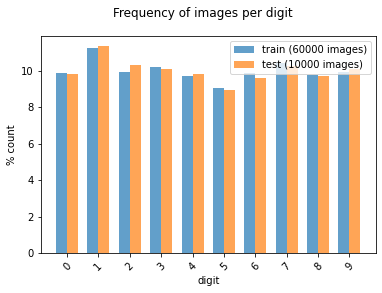

In [6]:
# create a histogram of the number of images in each class/digit:
def plot_bar(y, loc='left', relative=True):
    width = 0.35
    if loc == 'left':
        n = -0.5
    elif loc == 'right':
        n = 0.5
     
    # calculate counts per type and sort, to ensure their order
    unique, counts = np.unique(y, return_counts=True)
    sorted_index = np.argsort(unique)
    unique = unique[sorted_index]
     
    if relative:
        # plot as a percentage
        counts = 100*counts[sorted_index]/len(y)
        ylabel_text = '% count'
    else:
        # plot counts
        counts = counts[sorted_index]
        ylabel_text = 'count'
         
    xtemp = np.arange(len(unique))
    plt.bar(xtemp + n*width, counts, align='center', alpha=.7, width=width)
    plt.xticks(xtemp, unique, rotation=45)
    plt.xlabel('digit')
    plt.ylabel(ylabel_text)
 
plt.suptitle('Frequency of images per digit')
plot_bar(y_train, loc='left')
plot_bar(y_test, loc='right')
plt.legend([
    'train ({0} images)'.format(len(y_train)), 
    'test ({0} images)'.format(len(y_test)), 
]);

####**2.4) Visualize some of the training and test  images and their associated targets:**

* First implement a visualization functionality to visualize the number of randomly selected images:

In [7]:
"""
# A utility function to visualize multiple images:
"""
def visualize_images_and_labels(num_visualized_images = 25, dataset_flag = 1):
  """To visualize images.

      Keyword arguments:
         - num_visualized_images -- the number of visualized images (deafult 25)
         - dataset_flag -- 1: training dataset, 2: test dataset
      Return:
         - None
  """
  #--------------------------------------------
  # the suplot grid shape:
  #--------------------------------------------
  num_rows = 5
  # the number of columns
  num_cols = num_visualized_images // num_rows
  # setup the subplots axes
  fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(8, 10))
  # set a seed random number generator for reproducible results
  seed(random_state_seed)
  # iterate over the sub-plots
  for row in range(num_rows):
      for col in range(num_cols):
        # get the next figure axis
        ax = axes[row, col];
        # turn-off subplot axis
        ax.set_axis_off()
        #--------------------------------------------
        # if the dataset_flag = 1: Training data set
        #--------------------------------------------
        if ( dataset_flag == 1 ): 
          # generate a random image counter
          counter = randint(0,num_train_images)
          # get the training image
          image = np.squeeze(x_train[counter,:])
          # get the target associated with the image
          label = y_train[counter]
        #--------------------------------------------
        # dataset_flag = 2: Test data set
        #--------------------------------------------
        else: 
          # generate a random image counter
          counter = randint(0,num_test_images)
          # get the test image
          image = np.squeeze(x_test[counter,:])
          # get the target associated with the image
          label = y_test[counter]
        #--------------------------------------------
        # display the image
        #--------------------------------------------
        ax.imshow(image, cmap=plt.cm.gray_r, interpolation='nearest')
        # set the title showing the image label
        ax.set_title('y =' + str(label), size = 8)

#####**2.4.1) Visualize some of the training images and their associated targets:**

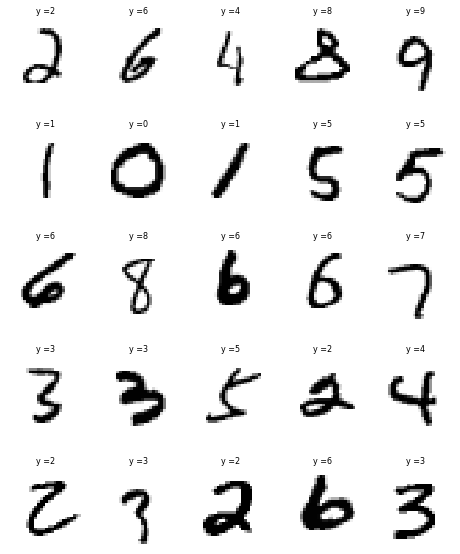

In [8]:
# call the function to visualize the training images
visualize_images_and_labels(num_visualized_images, 1)

#####**2.4.2) Visualize some of the test images and their associated targets:**

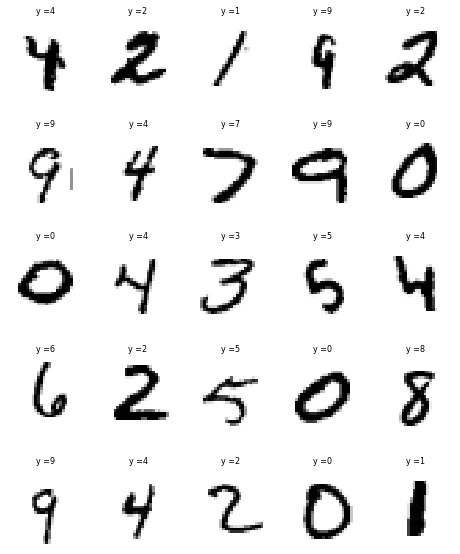

In [9]:
# call the function to visualize the test images
visualize_images_and_labels(num_visualized_images, 2)

####**2.7) Reshape the training and test images:**
* The training and test images are 2D grayscale images of size 28x28 pixels
* They need to be flattened to 1D vectors of size: 28x28

In [10]:
# Flatten the data
N, H, W = x_train.shape
# the vector length
D = H * W
# reshape the training features
x_train = x_train.reshape(-1, D)
# reshape the test features
x_test = x_test.reshape(-1, D)

#####**2.7.1) Examine the reshaped training and test images:**

In [11]:
#------------------------------------------------------
# Training data:
#------------------------------------------------------
print("----------------------------------------------")
print("Training data:")
print("----------------------------------------------")
print("x_train.shape: ", x_train.shape)
print("Number of training images: ", num_train_images)
print("Image size: ", x_train.shape[1:])
print("----------------------------------------------")


#------------------------------------------------------
# Test data:
#------------------------------------------------------
# the number of test images
num_test_images = x_test.shape[0]
print("----------------------------------------------")
print("Test data:")
print("----------------------------------------------")
print("x_test.shape: ", x_test.shape)
print("Number of test images: ", num_test_images)
print("Image size: ", x_test.shape[1:])
print("----------------------------------------------")

----------------------------------------------
Training data:
----------------------------------------------
x_train.shape:  (60000, 784)
Number of training images:  60000
Image size:  (784,)
----------------------------------------------
----------------------------------------------
Test data:
----------------------------------------------
x_test.shape:  (10000, 784)
Number of test images:  10000
Image size:  (784,)
----------------------------------------------


##**Part 3: Construct the GANs Model**
###**3.1) The Generator Model:**
* Define a function to to design and construct the Generator model:

In [12]:
# Design and construct the Generator model
def build_generator(latent_dim):
  # Input layer
  i = Input(shape=(latent_dim,))
  # Dense layer
  x = Dense(256, activation=LeakyReLU(alpha=0.2))(i)
  # BatchNormalization layer
  x = BatchNormalization(momentum=0.7)(x)
  # Dense layer
  x = Dense(512, activation=LeakyReLU(alpha=0.2))(x)
  # BatchNormalization layer
  x = BatchNormalization(momentum=0.7)(x)
  # Dense layer
  x = Dense(1024, activation=LeakyReLU(alpha=0.2))(x)
  # BatchNormalization layer
  x = BatchNormalization(momentum=0.7)(x)
  # Dense layer
  x = Dense(D, activation='tanh')(x)
  # constuct the Generator model
  model = Model(i, x)
  # return the constructed model
  return model

###**3.2) The Discriminator Model:**
* Define a function to design and construct the Discriminator model:

In [13]:
# Design and construct the Discriminator model
def build_discriminator(img_size):
  # Input layer
  i = Input(shape=(img_size,))
  # Dense layer
  x = Dense(512, activation=LeakyReLU(alpha=0.2))(i)
  # Dense layer
  x = Dense(256, activation=LeakyReLU(alpha=0.2))(x)
  # Dense layer
  x = Dense(1, activation='sigmoid')(x)
  # constuct the Generator model
  model = Model(i, x)
  # return the constructed model
  return model

##**Part 4: Construct and compile the GANs Models**
###**4.1) Construct and compile the Discriminator Model:**


In [14]:
#-----------------------------------------
# Build and compile the discriminator
#-----------------------------------------
# Build the Discriminator model
discriminator = build_discriminator(D)

# Compile the Discriminator model
discriminator.compile(
    loss='binary_crossentropy',
    optimizer=Adam(0.0002, 0.5),
    metrics=['accuracy'])

###**4.2) Construct and compile the Combined Model:**

In [15]:
#-----------------------------------------
# Build and compile the combined model
#-----------------------------------------
# Build the Generator model
generator = build_generator(latent_dim)

# Create an input to represent noise sample from latent space
z = Input(shape=(latent_dim,))

# Pass noise through generator to get an image
img = generator(z)

# Make sure only the generator is trained
discriminator.trainable = False

# The true output is fake, but we label them real!
fake_pred = discriminator(img)

# Create the combined model object
combined_model = Model(z, fake_pred)

# Compile the combined model
combined_model.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5))

##**Part 5: Train the GANs Model:**
###**5.1) First implment a utility function to generate random samples from the generator.**

In [16]:
# A function to generate a grid of 5x5 random samples from the generator
# and save them to a file
def sample_images(epoch):
  rows, cols = 5, 5
  noise = np.random.randn(rows * cols, latent_dim)
  imgs = generator.predict(noise)

  # Rescale images 0 - 1
  imgs = 0.5 * imgs + 0.5

  fig, axs = plt.subplots(rows, cols)
  idx = 0
  for i in range(rows):
    for j in range(cols):
      axs[i,j].imshow(imgs[idx].reshape(H, W), cmap='gray')
      axs[i,j].axis('off')
      idx += 1
  fig.savefig("gan_images/%d.png" % epoch)
  plt.close()

###**5.2) Start training the GANs models:**

In [17]:
# Create batch labels to use when calling train_on_batch
ones = np.ones(batch_size)
zeros = np.zeros(batch_size)

# Store the losses
d_losses = []
g_losses = []

# Create a folder to store generated images
if not os.path.exists('gan_images'):
  os.makedirs('gan_images')

# Main training loop
for epoch in range(epochs):
  #-------------------------------------------
  # Step 1: Train the discriminator model:
  #-------------------------------------------
  # Select a random batch of images
  idx = np.random.randint(0, x_train.shape[0], batch_size)
  real_imgs = x_train[idx]
  
  # Generate fake images
  noise = np.random.randn(batch_size, latent_dim)
  fake_imgs = generator.predict(noise)
  
  # Train the discriminator
  # both loss and accuracy are returned
  d_loss_real, d_acc_real = discriminator.train_on_batch(real_imgs, ones)
  d_loss_fake, d_acc_fake = discriminator.train_on_batch(fake_imgs, zeros)
  d_loss = 0.5 * (d_loss_real + d_loss_fake)
  d_acc  = 0.5 * (d_acc_real + d_acc_fake)
  
  #-------------------------------------------
  # Step 2: Train the combined model:
  #-------------------------------------------
  # generate random Gaussian normal
  noise = np.random.randn(batch_size, latent_dim)
  # train the combined model
  g_loss = combined_model.train_on_batch(noise, ones)
  
  # Do it again: generate random Gaussian normal
  noise = np.random.randn(batch_size, latent_dim)
  # train the combined model
  g_loss = combined_model.train_on_batch(noise, ones)
  
  # Save the losses
  d_losses.append(d_loss)
  g_losses.append(g_loss)
  # log the losses for certain epochs
  if epoch % 100 == 0:
    print(f"epoch: {epoch+1}/{epochs}, d_loss: {d_loss:.2f}, \
      d_acc: {d_acc:.2f}, g_loss: {g_loss:.2f}")
  # save the images for certain epochs
  if epoch % sample_period == 0:
    sample_images(epoch)


epoch: 1/30000, d_loss: 0.91,       d_acc: 0.14, g_loss: 0.64
epoch: 101/30000, d_loss: 0.16,       d_acc: 0.97, g_loss: 2.78
epoch: 201/30000, d_loss: 0.65,       d_acc: 0.67, g_loss: 1.26
epoch: 301/30000, d_loss: 0.73,       d_acc: 0.42, g_loss: 0.61
epoch: 401/30000, d_loss: 0.70,       d_acc: 0.47, g_loss: 0.61
epoch: 501/30000, d_loss: 0.69,       d_acc: 0.48, g_loss: 0.63
epoch: 601/30000, d_loss: 0.69,       d_acc: 0.48, g_loss: 0.66
epoch: 701/30000, d_loss: 0.70,       d_acc: 0.50, g_loss: 0.64
epoch: 801/30000, d_loss: 0.67,       d_acc: 0.55, g_loss: 0.69
epoch: 901/30000, d_loss: 0.67,       d_acc: 0.53, g_loss: 0.70
epoch: 1001/30000, d_loss: 0.66,       d_acc: 0.67, g_loss: 0.70
epoch: 1101/30000, d_loss: 0.68,       d_acc: 0.58, g_loss: 0.77
epoch: 1201/30000, d_loss: 0.65,       d_acc: 0.64, g_loss: 0.75
epoch: 1301/30000, d_loss: 0.69,       d_acc: 0.48, g_loss: 0.77
epoch: 1401/30000, d_loss: 0.67,       d_acc: 0.61, g_loss: 0.72
epoch: 1501/30000, d_loss: 0.66,     

##**Part 6: Evaluate the trained Discriminator and Generator models:**
###**6.1) Display the Training losses:**

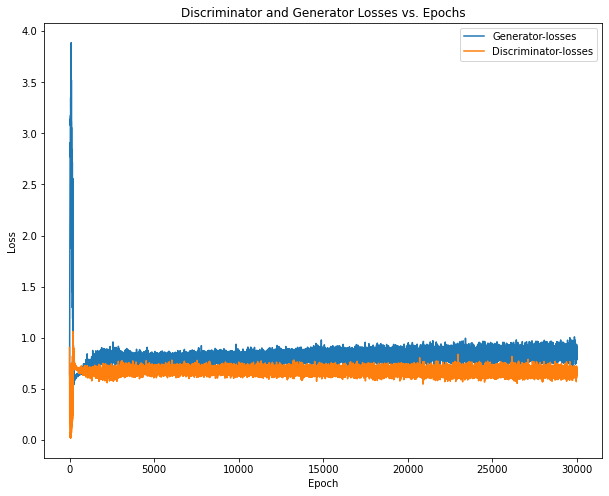

In [36]:
# create a figure and set its axis
fig_size = (10,8)
# create the figure 
plt.figure(figsize=fig_size)
# plot the generator model losses
plt.plot(g_losses, label='Generator-losses')
# plot the discriminator model losses
plt.plot(d_losses, label='Discriminator-losses')
# add legend
plt.legend()
# add xlabel
plt.xlabel('Epoch')
# add ylabel
plt.ylabel('Loss')
# add title
plt.title('Discriminator and Generator Losses vs. Epochs')
# display the figure
plt.show()

##**Part 7: Visualize some of the generated results:**
###**7.1) List the saved generated images at different epochs:**

In [19]:
# list the content of the saved images folder
!ls gan_images

0.png	   13500.png  17500.png  21500.png  25500.png  3000.png  7000.png
10000.png  14000.png  18000.png  22000.png  26000.png  3500.png  7500.png
1000.png   14500.png  18500.png  22500.png  26500.png  4000.png  8000.png
10500.png  15000.png  19000.png  23000.png  27000.png  4500.png  8500.png
11000.png  1500.png   19500.png  23500.png  27500.png  5000.png  9000.png
11500.png  15500.png  20000.png  24000.png  28000.png  500.png	 9500.png
12000.png  16000.png  2000.png	 24500.png  28500.png  5500.png
12500.png  16500.png  20500.png  25000.png  29000.png  6000.png
13000.png  17000.png  21000.png  2500.png   29500.png  6500.png


###**7.2) Visualize sample generated images after different epochs:**


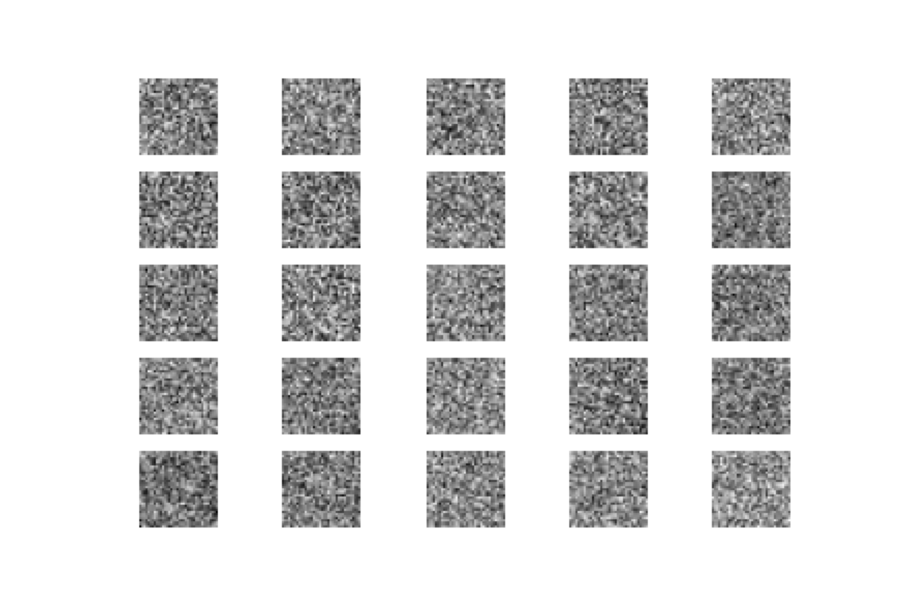

In [21]:
#------------------------------------------------
# Display sample generated images at epoch: 0
#------------------------------------------------
# these should be pure Gaussian noise
im = imread('gan_images/0.png')
# create a figure and set its axis
fig_size = (16,16)
# create the figure 
plt.figure(figsize=fig_size)
# display the image
plt.imshow(im)
# hide the axes
plt.axis('off')
# display the figure
plt.show()

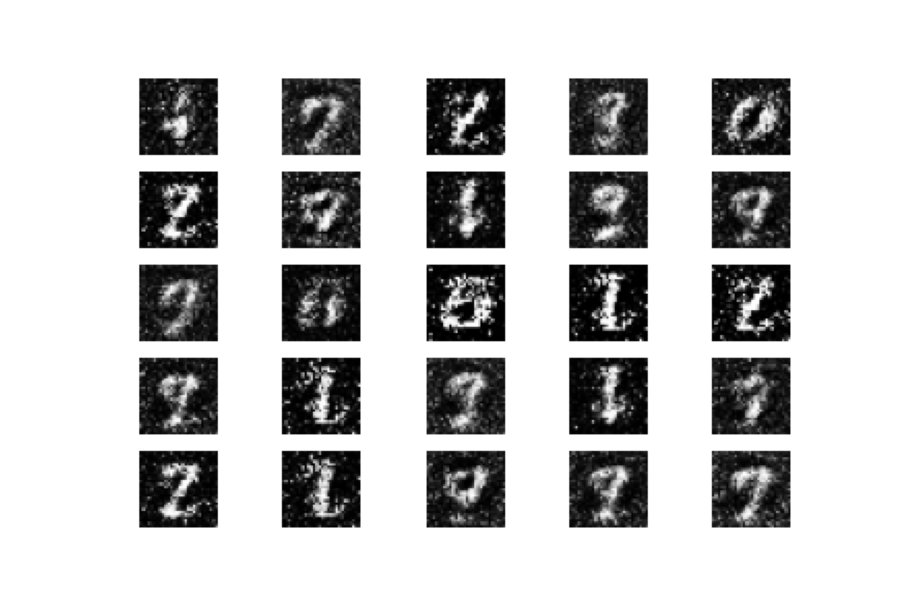

In [27]:
#------------------------------------------------
# Display sample generated images at epoch: 1000
#------------------------------------------------
# these should resemble hand-written digits
im = imread('gan_images/1000.png')
# create a figure and set its axis
fig_size = (16,16)
# create the figure 
plt.figure(figsize=fig_size)
# display the image
plt.imshow(im)
# hide the axes
plt.axis('off')
# display the figure
plt.show()

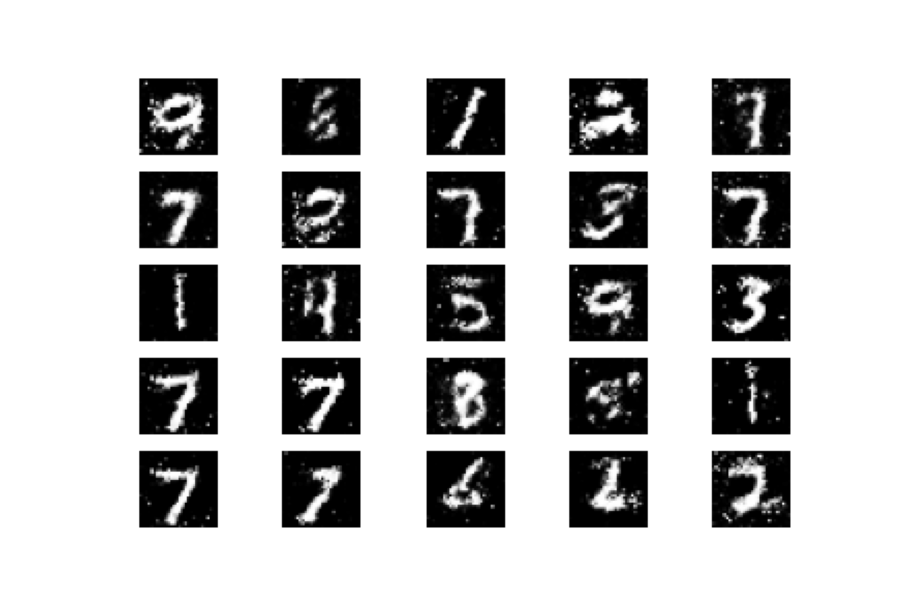

In [28]:
#------------------------------------------------
# Display sample generated images at epoch: 5000
#------------------------------------------------
# these should resemble hand-written digits
im = imread('gan_images/5000.png')
# create a figure and set its axis
fig_size = (16,16)
# create the figure 
plt.figure(figsize=fig_size)
# display the image
plt.imshow(im)
# hide the axes
plt.axis('off')
# display the figure
plt.show()

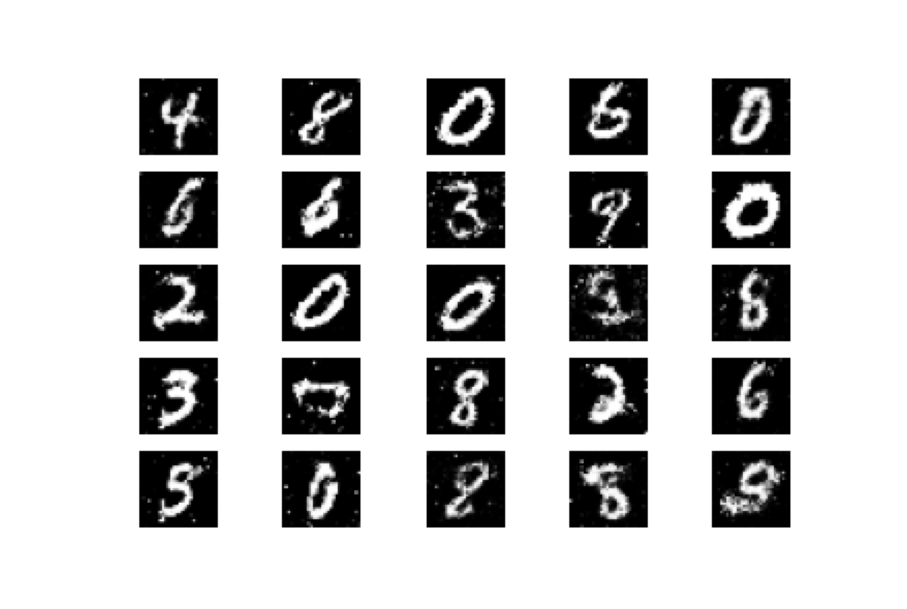

In [29]:
#------------------------------------------------
# Display sample generated images at epoch: 10000
#------------------------------------------------
# these should resemble hand-written digits
im = imread('gan_images/10000.png')
# create a figure and set its axis
fig_size = (16,16)
# create the figure 
plt.figure(figsize=fig_size)
# display the image
plt.imshow(im)
# hide the axes
plt.axis('off')
# display the figure
plt.show()

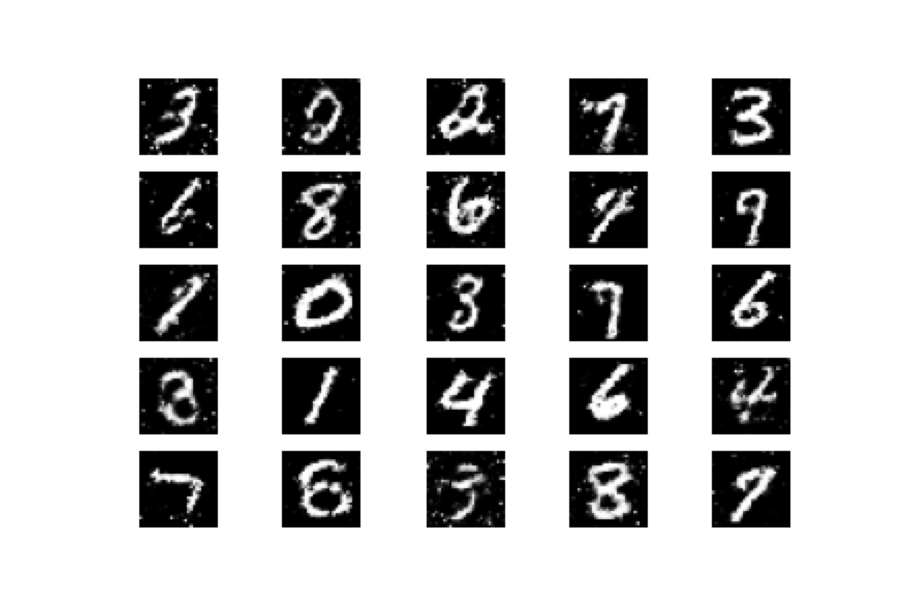

In [30]:
#------------------------------------------------
# Display sample generated images at epoch: 20000
#------------------------------------------------
# these should resemble hand-written digits
im = imread('gan_images/20000.png')
# create a figure and set its axis
fig_size = (16,16)
# create the figure 
plt.figure(figsize=fig_size)
# display the image
plt.imshow(im)
# hide the axes
plt.axis('off')
# display the figure
plt.show()

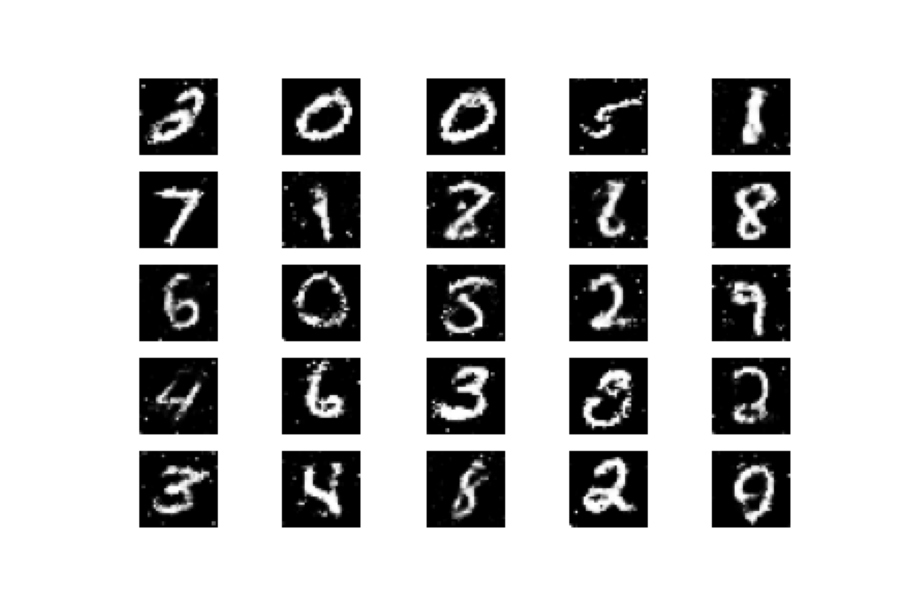

In [32]:
#------------------------------------------------
# Display sample generated images the end of 
# training at epoch: 30,0000
#------------------------------------------------
# these should resemble hand-written digits
im = imread('gan_images/29500.png')
# create a figure and set its axis
fig_size = (16,16)
# create the figure 
plt.figure(figsize=fig_size)
# display the image
plt.imshow(im)
# hide the axes
plt.axis('off')
# display the figure
plt.show()

##**Part 8: Display a successful execution message:**

In [37]:
# display a final message
# current time
now = datetime.datetime.now()
# display a message
print('Program executed successfully on: '+ str(now.strftime("%Y-%m-%d %H:%M:%S") + "...Goodbye!\n"))

Program executed successfully on: 2021-05-10 03:29:48...Goodbye!

